# Comparison of all the models

Finally, I will compare all the models (2 ARIMA, 2 simple, VAR, VAR sinus) of all the weather parameters. I will plot histograms of the absolute error of the models compared to the actual data.

In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
import os
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.api import VAR

In [2]:
# data

station_id=5001
# read the .csv file into a DataFrame
file_path = os.path.join(r'D:\FMF magisterij\Matematika z računalnikom', f'ELES-MAS-{station_id}-2020-2023.csv.gz')
data = pd.read_csv(file_path, compression='gzip')
data = data[data['data_validity'] <= 32]
data.drop('measurement_location_inst_id', axis=1, inplace=True)
df=pd.DataFrame(data)
df['timestamp'] = pd.to_datetime(df['acquisition_timestamp'], utc=True)


# rearrange the data
new_data = df.pivot_table(index='timestamp', columns='parameter_type', values='value').reset_index()

# ensure 'acquisition_timestamp' is in datetime format
new_data['timestamp'] = pd.to_datetime(new_data['timestamp'])

new_data.set_index('timestamp', inplace=True)


# fill NaN values in the row with the values of next row with non NaN values
new_data = new_data.fillna(method='bfill')

#print('index type :',type(new_data.index))
#new_data.head()

# count the NaN values
nan_count = new_data.isna().sum()
#print(nan_count)
# NO nan values

# check for missing measurements (skipped times)
complete_range = pd.date_range(start=new_data.index.min(), end=new_data.index.max(), freq='5T')
missing_timestamps = complete_range.difference(new_data.index)
#print(f"missing time stamps ={len(missing_timestamps)}")
# print(complete_range)
df_complete_range = pd.DataFrame(index=complete_range)
#print(f"df complete range = {len(df_complete_range)}")

# we have 271508 measurements, there are 5112 missing measurment out of 276620 time steps in the whole time range

# merge all the measurements with all the time steps. missing measurment will be NaN values for now
new_data_incomplete = df_complete_range.merge(new_data, left_index=True, right_index=True, how='left')
#print(new_data_incomplete.isna().sum()) # okay

# missing measurements are filled with the next available measurement
new_data_all = new_data_incomplete.bfill()

# fill NaN values in the row with the values of next row with non-NaN values
new_data_all = new_data_all.fillna(method='bfill')

# print(new_data_all)
#print(new_data_all.isna().sum()) # okay

str(new_data_all.index.dtype) # okay

# resampled the data hourly with mean.
new_data_all_resampled=new_data_all.resample('1H').mean()
print(new_data_all_resampled)

                           AIR_PRESSURE  AMBIENT_TEMPERATURE  RAIN_INTENSITY  \
2020-10-13 10:00:00+00:00    952.762500             7.687500           0.000   
2020-10-13 11:00:00+00:00    952.366667             8.958333           0.000   
2020-10-13 12:00:00+00:00    951.783333            10.183333           0.000   
2020-10-13 13:00:00+00:00    951.691667            10.716667           0.000   
2020-10-13 14:00:00+00:00    951.508333            10.833333           0.000   
...                                 ...                  ...             ...   
2023-05-31 17:00:00+00:00    964.141667            18.708333           0.000   
2023-05-31 18:00:00+00:00    964.275000            17.141667           0.000   
2023-05-31 19:00:00+00:00    964.991667            15.525000           0.275   
2023-05-31 20:00:00+00:00    965.066667            14.341667           0.000   
2023-05-31 21:00:00+00:00    964.900000            13.983333           0.000   

                           RELATIVE_HUM

In [3]:
# simple model 1: today = tomorrow
simple_1 = new_data_all_resampled.copy()
simple_1.iloc[24:] = new_data_all_resampled.iloc[:-24].values
simple_1.iloc[:24] = new_data_all_resampled.iloc[:24].values  # first 24hrs stay the same


In [30]:
# simple model 2: last 3 days' average is today

simple_2 = new_data_all_resampled.copy()
simple_2.iloc[:72] = new_data_all_resampled.iloc[:72]
for i in range(72, len(new_data_all_resampled)):
    current_time = new_data_all_resampled.index[i]
    hour_of_day = current_time.hour
    
    last_3_days = [
        current_time - pd.Timedelta(days=1),
        current_time - pd.Timedelta(days=2),
        current_time - pd.Timedelta(days=3)
    ]
    
    values = [new_data_all_resampled.loc[dt] if dt in new_data_all_resampled.index else np.nan for dt in last_3_days]
    
    forecast_value = np.nanmean(values, axis=0)
    
    simple_2.iloc[i] = forecast_value


In [31]:
# VAR for all
model = VAR(new_data_all_resampled)
results = model.fit(maxlags=15, ic='aic')
params = results.params
var = results.fittedvalues

In [32]:
# VAR sinus for all
data_sinus = new_data_all_resampled
data_sinus['hour'] = data_sinus.index.hour
data_sinus['sinus_time'] = np.sin((data_sinus['hour'] / 24) * 2 * np.pi + np.pi / 2)
data_sinus.drop(columns=['hour'], inplace=True)
model = VAR(data_sinus)
results = model.fit(maxlags=15, ic='aic')
params = results.params
sinus = results.fittedvalues


## Ambient temperature

In [36]:
# actual data
temp_actual = new_data_all_resampled['AMBIENT_TEMPERATURE']

# arima 1
model_215 = ARIMA(temp_actual, order=(2,1,5))
fit_215 = model_215.fit()
temp_arima_215 = fit_215.fittedvalues

# arima 2
model_412 = ARIMA(temp_actual, order=(4,1,2))
fit_412 = model_412.fit()
temp_arima_412 = fit_412.fittedvalues

# simple model 1
temp_sim_1 = simple_1['AMBIENT_TEMPERATURE']

# simple model 2
temp_sim_2 = simple_2['AMBIENT_TEMPERATURE']

# VAR
temp_var = var['AMBIENT_TEMPERATURE']

# VAR sinus
temp_sin = sinus['AMBIENT_TEMPERATURE']

In [37]:
# errors
error_arima_215 = (temp_actual - temp_arima_215).dropna()
error_arima_412 = (temp_actual - temp_arima_412).dropna()
error_simple_1 = (temp_actual - temp_sim_1).dropna()
error_simple_2 = (temp_actual - temp_sim_2).dropna()
error_var = (temp_actual - temp_var).dropna()
error_sinus = (temp_actual - temp_sin).dropna()

print(temp_sim_2)


2020-10-13 10:00:00+00:00     7.687500
2020-10-13 11:00:00+00:00     8.958333
2020-10-13 12:00:00+00:00    10.183333
2020-10-13 13:00:00+00:00    10.716667
2020-10-13 14:00:00+00:00    10.833333
                               ...    
2023-05-31 17:00:00+00:00    20.902778
2023-05-31 18:00:00+00:00    19.350000
2023-05-31 19:00:00+00:00    17.186111
2023-05-31 20:00:00+00:00    15.050000
2023-05-31 21:00:00+00:00    13.561111
Freq: H, Name: AMBIENT_TEMPERATURE, Length: 23052, dtype: float64


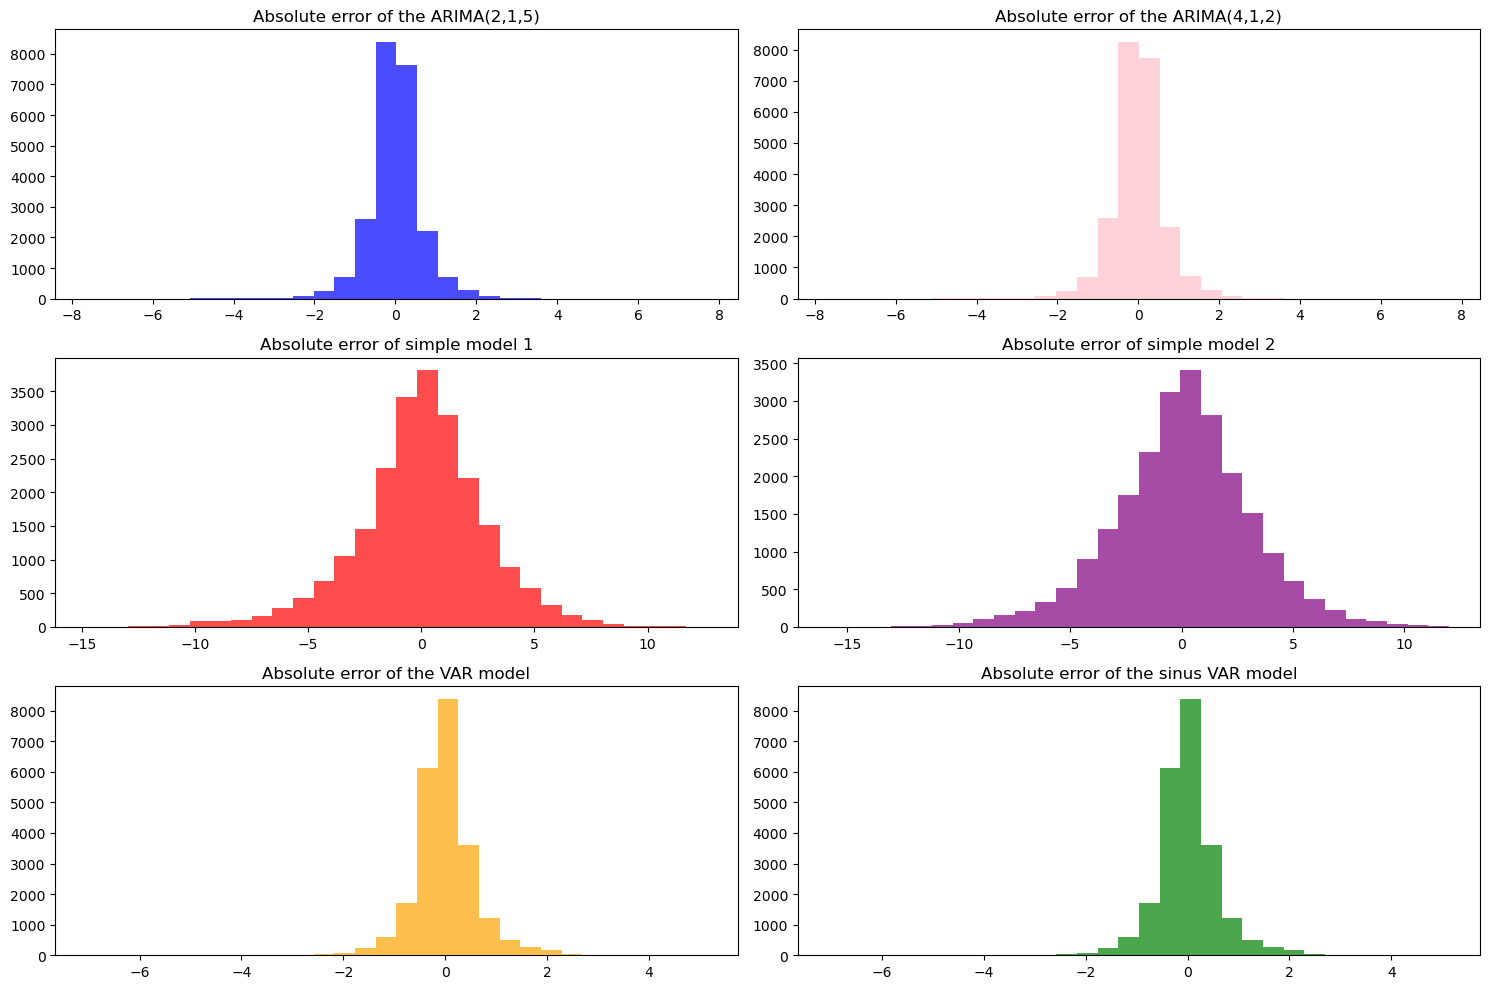

In [38]:
# histograms of the errors

plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.hist(error_arima_215, bins=30, color='blue', alpha=0.7)
plt.title('Absolute error of the ARIMA(2,1,5)')

plt.subplot(3, 2, 2)
plt.hist(error_arima_412, bins=30, color='pink', alpha=0.7)
plt.title('Absolute error of the ARIMA(4,1,2)')

plt.subplot(3, 2, 3)
plt.hist(error_simple_1, bins=30, color='red', alpha=0.7)
plt.title('Absolute error of simple model 1')

plt.subplot(3, 2, 4)
plt.hist(error_simple_2, bins=30, color='purple', alpha=0.7)
plt.title('Absolute error of simple model 2')

plt.subplot(3, 2, 5)
plt.hist(error_var, bins=30, color='orange', alpha=0.7)
plt.title('Absolute error of the VAR model')

plt.subplot(3, 2, 6)
plt.hist(error_sinus, bins=30, color='green', alpha=0.7)
plt.title('Absolute error of the sinus VAR model')

plt.tight_layout()
plt.show()

## Air pressure

In [39]:
# actual data
press_actual = new_data_all_resampled['AIR_PRESSURE']

# arima 1
model_301 = ARIMA(temp_actual, order=(3,0,1))
fit_301 = model_301.fit()
press_arima_301 = fit_301.fittedvalues

# arima 2
model_315 = ARIMA(temp_actual, order=(3,1,5))
fit_315 = model_315.fit()
press_arima_315 = fit_315.fittedvalues

# simple model 1
press_sim_1 = simple_1['AIR_PRESSURE']

# simple model 2
press_sim_2 = simple_2['AIR_PRESSURE']

# VAR
press_var = var['AIR_PRESSURE']

# VAR sinus
press_sin = sinus['AIR_PRESSURE']

In [40]:
# errors
error_arima_301 = (press_actual - press_arima_301).dropna()
error_arima_315 = (press_actual - press_arima_315).dropna()
error_simple_1_press = (press_actual - press_sim_1).dropna()
error_simple_2_press = (press_actual - press_sim_2).dropna()
error_var_press = (press_actual - press_var).dropna()
error_sinus_press = (press_actual - press_sin).dropna()

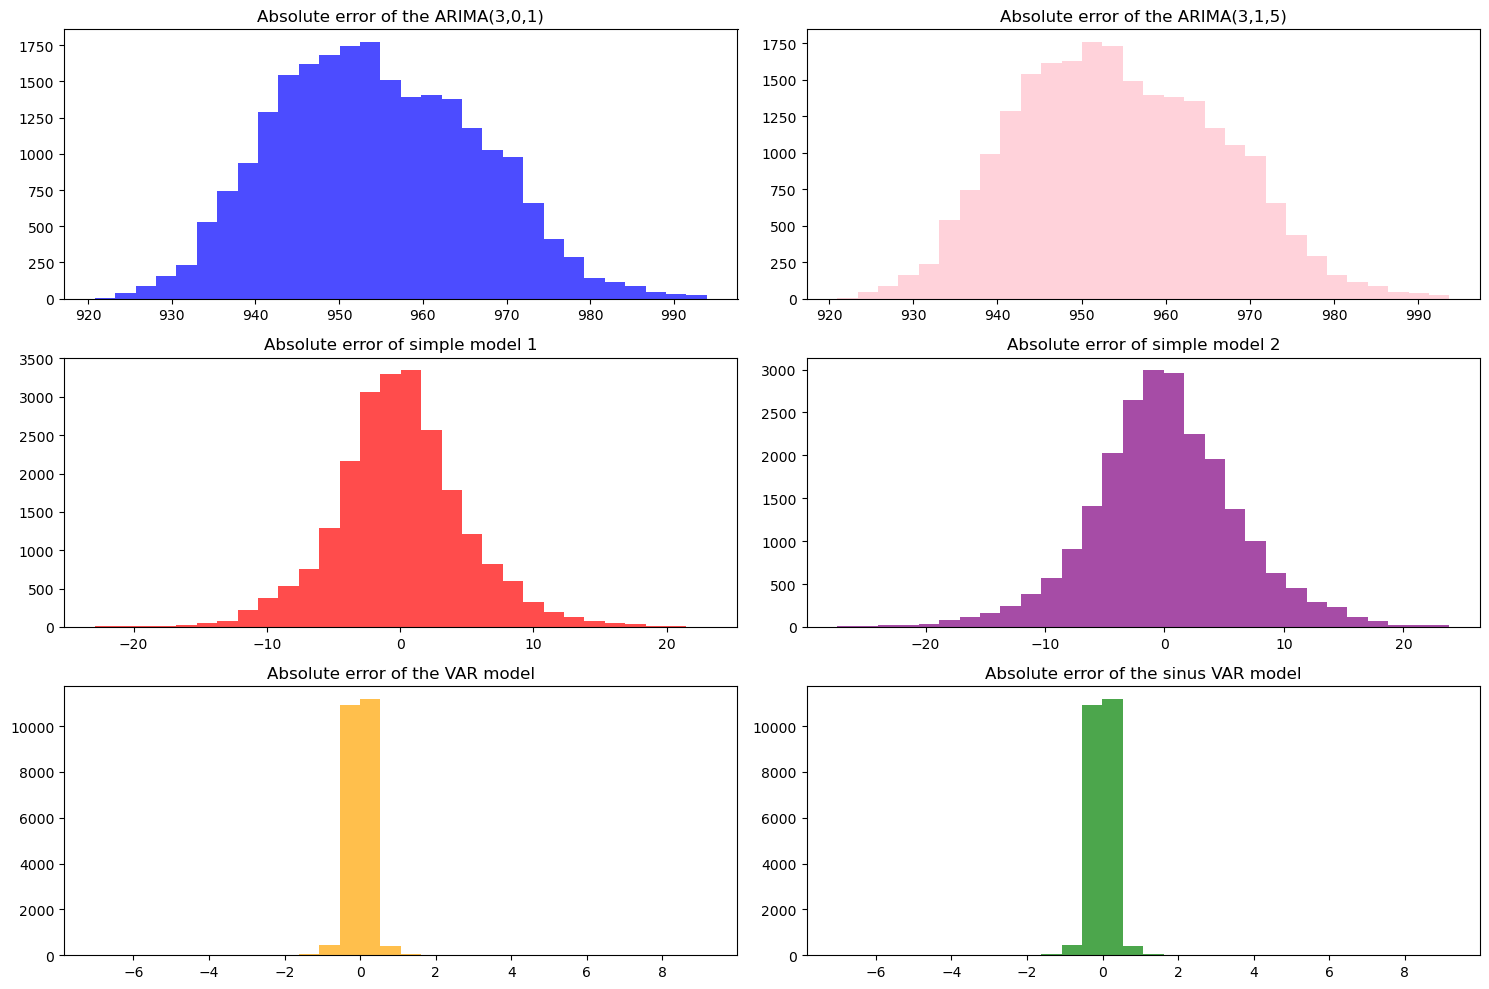

In [41]:
# histograms of the errors

plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.hist(error_arima_301, bins=30, color='blue', alpha=0.7)
plt.title('Absolute error of the ARIMA(3,0,1)')

plt.subplot(3, 2, 2)
plt.hist(error_arima_315, bins=30, color='pink', alpha=0.7)
plt.title('Absolute error of the ARIMA(3,1,5)')

plt.subplot(3, 2, 3)
plt.hist(error_simple_1_press, bins=30, color='red', alpha=0.7)
plt.title('Absolute error of simple model 1')

plt.subplot(3, 2, 4)
plt.hist(error_simple_2_press, bins=30, color='purple', alpha=0.7)
plt.title('Absolute error of simple model 2')

plt.subplot(3, 2, 5)
plt.hist(error_var_press, bins=30, color='orange', alpha=0.7)
plt.title('Absolute error of the VAR model')

plt.subplot(3, 2, 6)
plt.hist(error_sinus_press, bins=30, color='green', alpha=0.7)
plt.title('Absolute error of the sinus VAR model')

plt.tight_layout()
plt.show()

## Rain intensity

In [42]:
# actual data
rain_actual = new_data_all_resampled['RAIN_INTENSITY']

# arima 1
model_202 = ARIMA(rain_actual, order=(2,0,2))
fit_202 = model_202.fit()
rain_arima_202 = fit_202.fittedvalues

# arima 2
model_301 = ARIMA(rain_actual, order=(3,0,1))
fit_301 = model_301.fit()
rain_arima_301 = fit_301.fittedvalues

# simple model 1
rain_sim_1 = simple_1['RAIN_INTENSITY']

# simple model 2
rain_sim_2 = simple_2['RAIN_INTENSITY']

# VAR
rain_var = var['RAIN_INTENSITY']

# VAR sinus
rain_sin = sinus['RAIN_INTENSITY']

In [43]:
# errors
error_arima_202 = (rain_actual - rain_arima_202).dropna()
error_arima_301 = (rain_actual - rain_arima_301).dropna()
error_simple_1_rain = (rain_actual - rain_sim_1).dropna()
error_simple_2_rain = (rain_actual - rain_sim_2).dropna()
error_var_rain = (rain_actual - rain_var).dropna()
error_sinus_rain = (rain_actual - rain_sin).dropna()

print(error_simple_2_rain)

2020-10-13 10:00:00+00:00    0.000
2020-10-13 11:00:00+00:00    0.000
2020-10-13 12:00:00+00:00    0.000
2020-10-13 13:00:00+00:00    0.000
2020-10-13 14:00:00+00:00    0.000
                             ...  
2023-05-31 17:00:00+00:00    0.000
2023-05-31 18:00:00+00:00    0.000
2023-05-31 19:00:00+00:00    0.275
2023-05-31 20:00:00+00:00    0.000
2023-05-31 21:00:00+00:00    0.000
Freq: H, Name: RAIN_INTENSITY, Length: 23052, dtype: float64


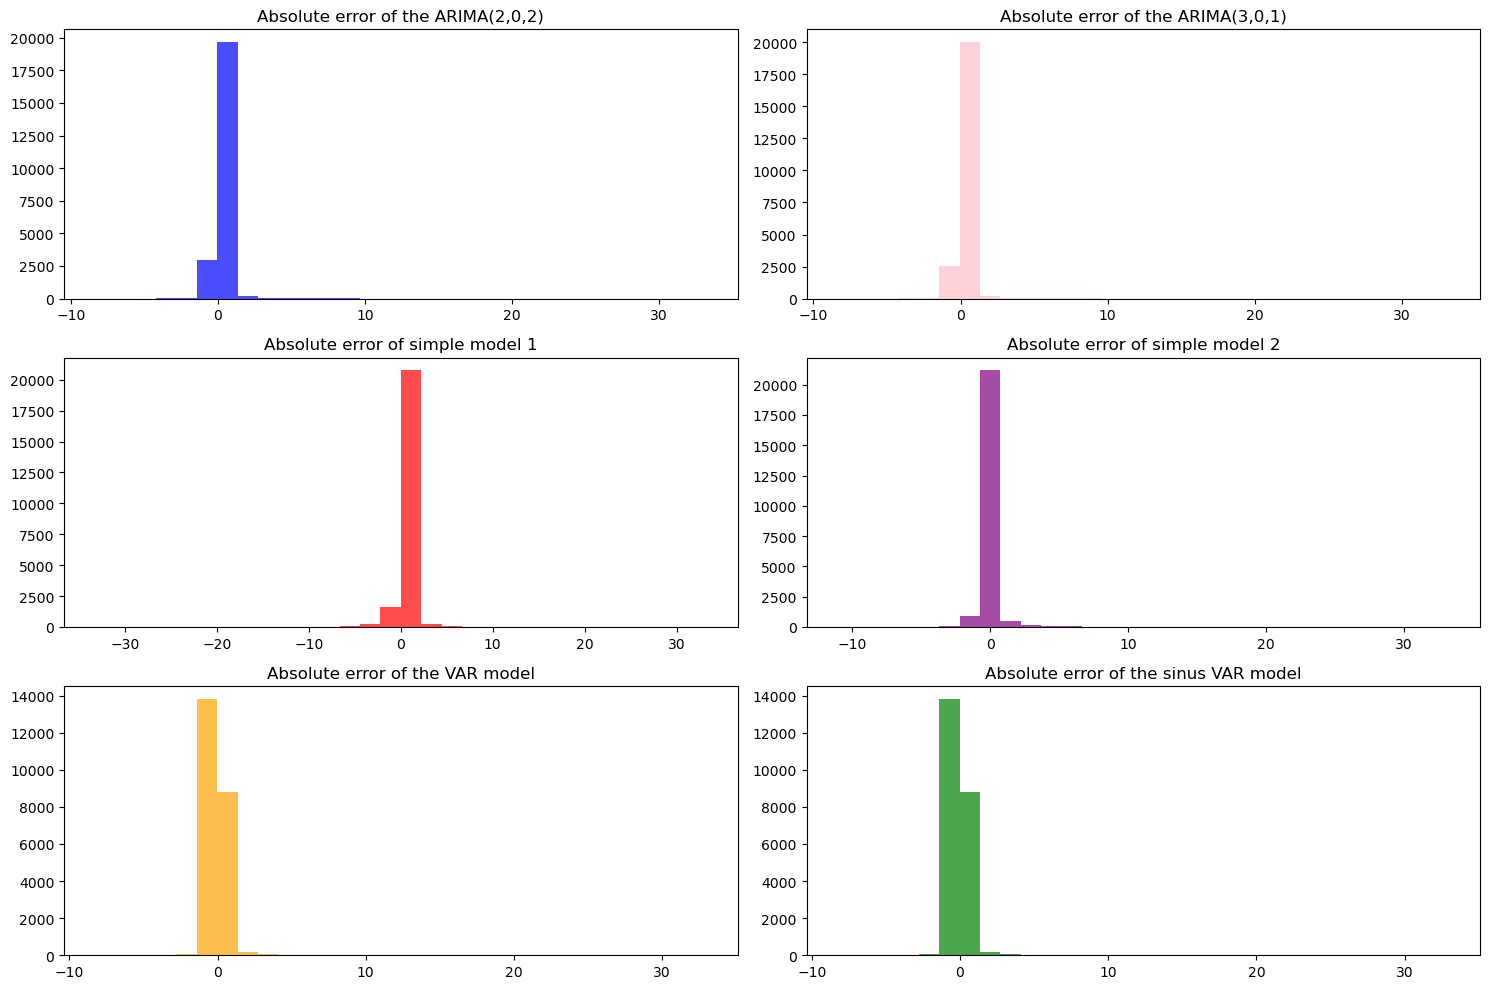

In [44]:
# histograms of the errors

plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.hist(error_arima_202, bins=30, color='blue', alpha=0.7)
plt.title('Absolute error of the ARIMA(2,0,2)')

plt.subplot(3, 2, 2)
plt.hist(error_arima_301, bins=30, color='pink', alpha=0.7)
plt.title('Absolute error of the ARIMA(3,0,1)')

plt.subplot(3, 2, 3)
plt.hist(error_simple_1_rain, bins=30, color='red', alpha=0.7)
plt.title('Absolute error of simple model 1')

plt.subplot(3, 2, 4)
plt.hist(error_simple_2_rain, bins=30, color='purple', alpha=0.7)
plt.title('Absolute error of simple model 2')

plt.subplot(3, 2, 5)
plt.hist(error_var_rain, bins=30, color='orange', alpha=0.7)
plt.title('Absolute error of the VAR model')

plt.subplot(3, 2, 6)
plt.hist(error_sinus_rain, bins=30, color='green', alpha=0.7)
plt.title('Absolute error of the sinus VAR model')

plt.tight_layout()
plt.show()

## Relative humidity

In [45]:
# actual data
hum_actual = new_data_all_resampled['RELATIVE_HUMIDITY']

# arima 1
model_211 = ARIMA(hum_actual, order=(2,1,1))
fit_211 = model_211.fit()
hum_arima_211 = fit_211.fittedvalues

# arima 2
model_304 = ARIMA(hum_actual, order=(3,0,4))
fit_304 = model_304.fit()
hum_arima_304 = fit_304.fittedvalues

# simple model 1
hum_sim_1 = simple_1['RELATIVE_HUMIDITY']

# simple model 2
hum_sim_2 = simple_2['RELATIVE_HUMIDITY']

# VAR
hum_var = var['RELATIVE_HUMIDITY']

# VAR sinus
hum_sin = sinus['RELATIVE_HUMIDITY']

In [46]:
# errors
error_arima_211 = (hum_actual - hum_arima_211).dropna()
error_arima_304 = (hum_actual - hum_arima_304).dropna()
error_simple_1_hum = (hum_actual - hum_sim_1).dropna()
error_simple_2_hum = (hum_actual - hum_sim_2).dropna()
error_var_hum = (hum_actual - hum_var).dropna()
error_sinus_hum = (hum_actual - hum_sin).dropna()

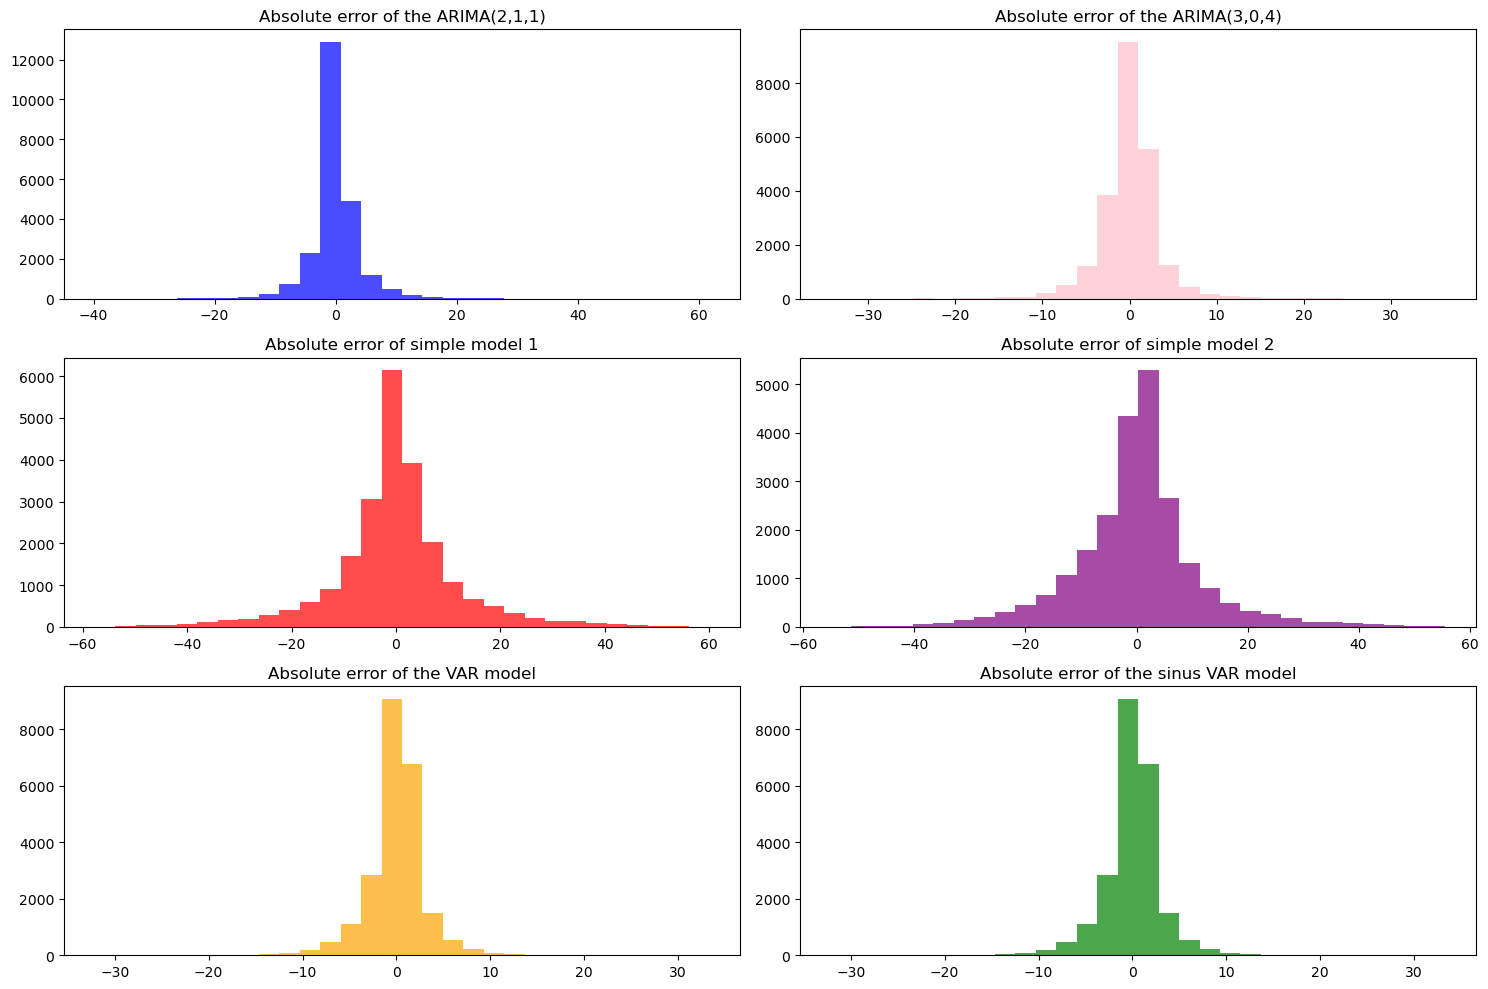

In [47]:
# histograms of the errors

plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.hist(error_arima_211, bins=30, color='blue', alpha=0.7)
plt.title('Absolute error of the ARIMA(2,1,1)')

plt.subplot(3, 2, 2)
plt.hist(error_arima_304, bins=30, color='pink', alpha=0.7)
plt.title('Absolute error of the ARIMA(3,0,4)')

plt.subplot(3, 2, 3)
plt.hist(error_simple_1_hum, bins=30, color='red', alpha=0.7)
plt.title('Absolute error of simple model 1')

plt.subplot(3, 2, 4)
plt.hist(error_simple_2_hum, bins=30, color='purple', alpha=0.7)
plt.title('Absolute error of simple model 2')

plt.subplot(3, 2, 5)
plt.hist(error_var_hum, bins=30, color='orange', alpha=0.7)
plt.title('Absolute error of the VAR model')

plt.subplot(3, 2, 6)
plt.hist(error_sinus_hum, bins=30, color='green', alpha=0.7)
plt.title('Absolute error of the sinus VAR model')

plt.tight_layout()
plt.show()

## Solar radiation intensity

In [48]:
# actual data
solar_actual = new_data_all_resampled['SOLAR_RADIATION_INTENSITY']

# arima 1
model_312 = ARIMA(solar_actual, order=(3,1,2))
fit_312 = model_312.fit()
solar_arima_312 = fit_312.fittedvalues

# arima 2
model_214 = ARIMA(solar_actual, order=(2,1,4))
fit_214 = model_214.fit()
solar_arima_214 = fit_214.fittedvalues

# simple model 1
solar_sim_1 = simple_1['SOLAR_RADIATION_INTENSITY']

# simple model 2
solar_sim_2 = simple_2['SOLAR_RADIATION_INTENSITY']

# VAR
solar_var = var['SOLAR_RADIATION_INTENSITY']

# VAR sinus
solar_sin = sinus['SOLAR_RADIATION_INTENSITY']

In [49]:
# errors
error_arima_312 = (solar_actual - solar_arima_312).dropna()
error_arima_214 = (solar_actual - solar_arima_214).dropna()
error_simple_1_solar = (solar_actual - solar_sim_1).dropna()
error_simple_2_solar = (solar_actual - solar_sim_2).dropna()
error_var_solar = (solar_actual - solar_var).dropna()
error_sinus_solar = (solar_actual - solar_sin).dropna()

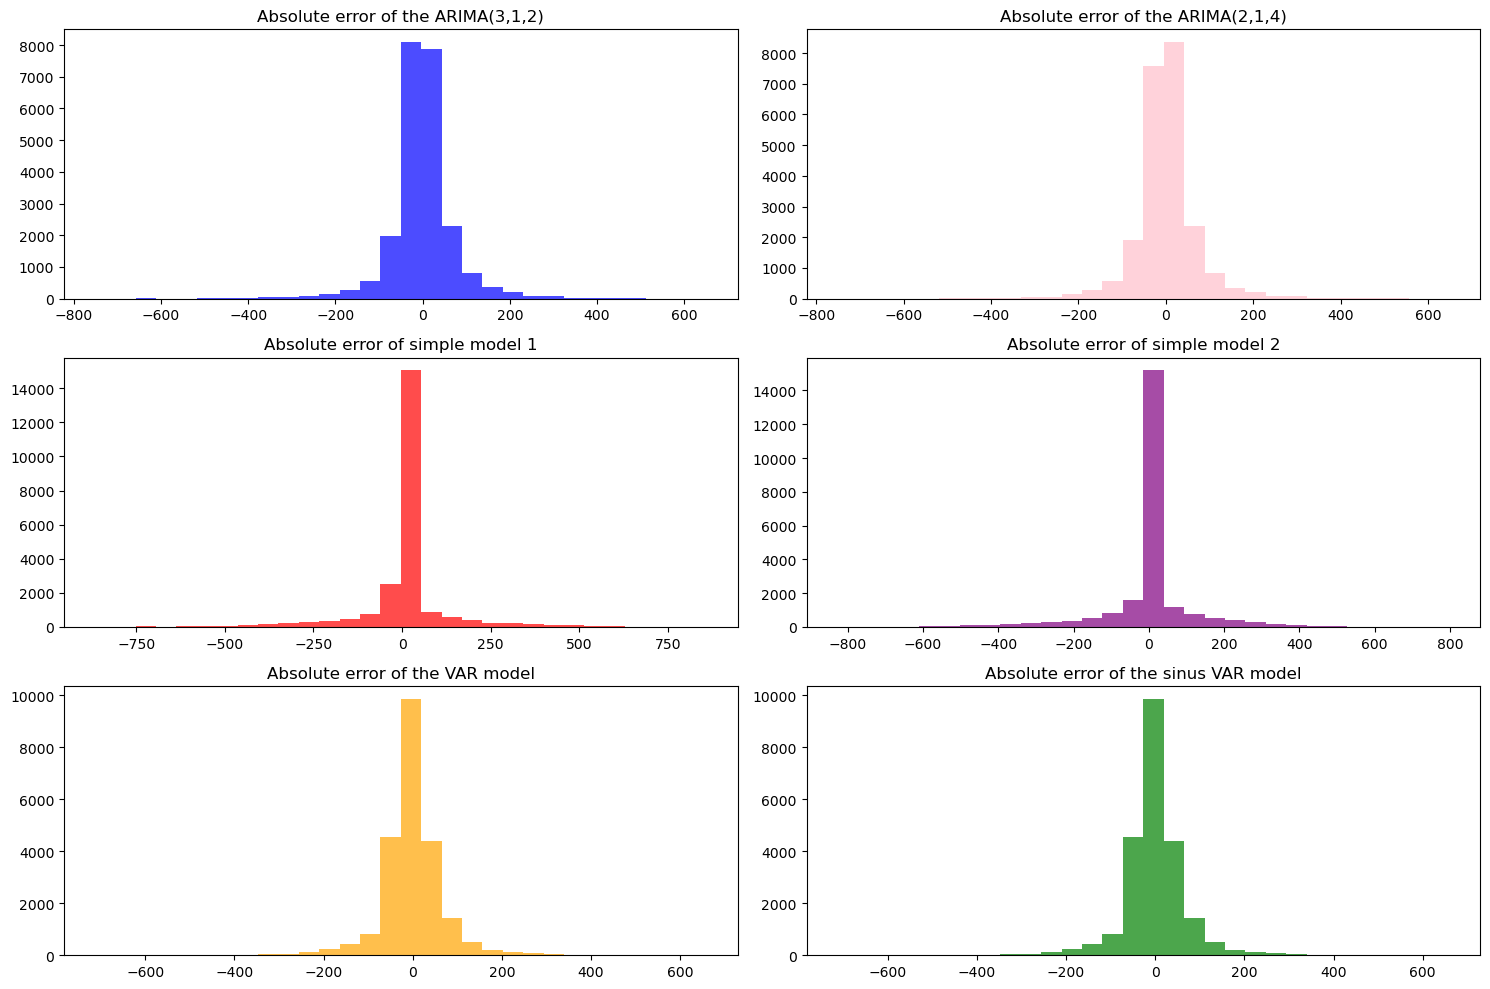

In [50]:
# histograms of the errors

plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.hist(error_arima_312, bins=30, color='blue', alpha=0.7)
plt.title('Absolute error of the ARIMA(3,1,2)')

plt.subplot(3, 2, 2)
plt.hist(error_arima_214, bins=30, color='pink', alpha=0.7)
plt.title('Absolute error of the ARIMA(2,1,4)')

plt.subplot(3, 2, 3)
plt.hist(error_simple_1_solar, bins=30, color='red', alpha=0.7)
plt.title('Absolute error of simple model 1')

plt.subplot(3, 2, 4)
plt.hist(error_simple_2_solar, bins=30, color='purple', alpha=0.7)
plt.title('Absolute error of simple model 2')

plt.subplot(3, 2, 5)
plt.hist(error_var_solar, bins=30, color='orange', alpha=0.7)
plt.title('Absolute error of the VAR model')

plt.subplot(3, 2, 6)
plt.hist(error_sinus_solar, bins=30, color='green', alpha=0.7)
plt.title('Absolute error of the sinus VAR model')

plt.tight_layout()
plt.show()

## Wind direction

In [51]:
# actual data
wind_actual = new_data_all_resampled['WIND_DIRECTION']

# arima 1
model_312 = ARIMA(wind_actual, order=(3,1,2))
fit_312 = model_312.fit()
wind_arima_312 = fit_312.fittedvalues

# arima 2
model_501 = ARIMA(wind_actual, order=(5,0,1))
fit_501 = model_501.fit()
wind_arima_501 = fit_501.fittedvalues

# simple model 1
wind_sim_1 = simple_1['WIND_DIRECTION']

# simple model 2
wind_sim_2 = simple_2['WIND_DIRECTION']

# VAR
wind_var = var['WIND_DIRECTION']

# VAR sinus
wind_sin = sinus['WIND_DIRECTION']

In [52]:
# errors
error_arima_312 = (wind_actual - wind_arima_312).dropna()
error_arima_501 = (wind_actual - wind_arima_501).dropna()
error_simple_1_wind = (wind_actual - wind_sim_1).dropna()
error_simple_2_wind = (wind_actual - wind_sim_2).dropna()
error_var_wind = (wind_actual - wind_var).dropna()
error_sinus_wind = (wind_actual - wind_sin).dropna()

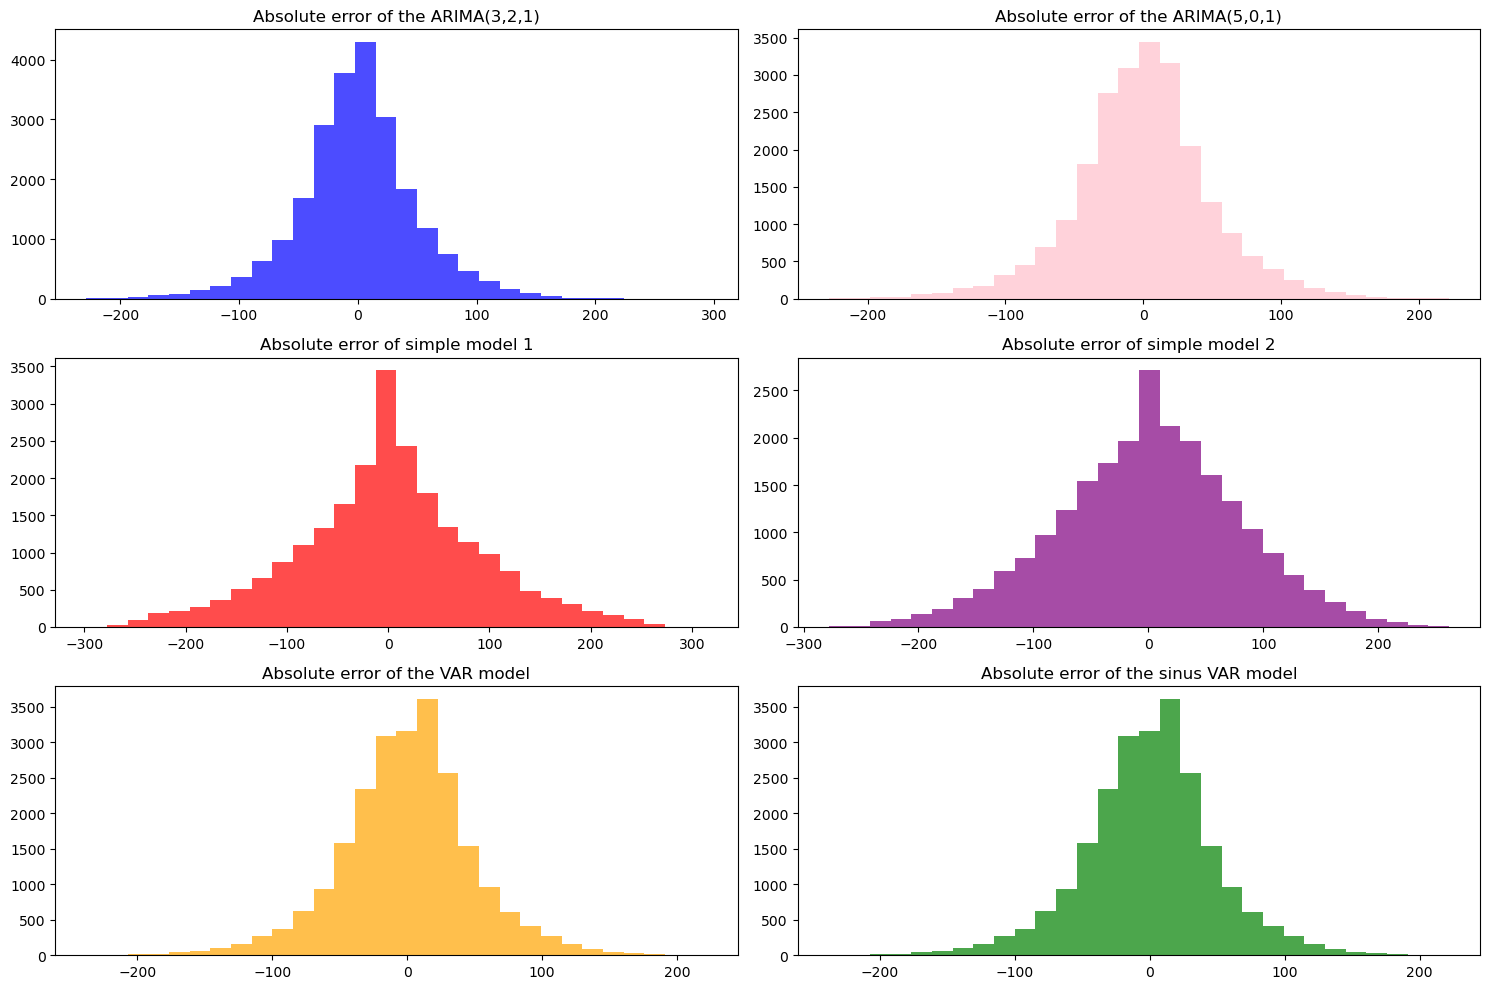

In [53]:
# histograms of the errors

plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.hist(error_arima_312, bins=30, color='blue', alpha=0.7)
plt.title('Absolute error of the ARIMA(3,2,1)')

plt.subplot(3, 2, 2)
plt.hist(error_arima_501, bins=30, color='pink', alpha=0.7)
plt.title('Absolute error of the ARIMA(5,0,1)')

plt.subplot(3, 2, 3)
plt.hist(error_simple_1_wind, bins=30, color='red', alpha=0.7)
plt.title('Absolute error of simple model 1')

plt.subplot(3, 2, 4)
plt.hist(error_simple_2_wind, bins=30, color='purple', alpha=0.7)
plt.title('Absolute error of simple model 2')

plt.subplot(3, 2, 5)
plt.hist(error_var_wind, bins=30, color='orange', alpha=0.7)
plt.title('Absolute error of the VAR model')

plt.subplot(3, 2, 6)
plt.hist(error_sinus_wind, bins=30, color='green', alpha=0.7)
plt.title('Absolute error of the sinus VAR model')

plt.tight_layout()
plt.show()

## Wind speed

In [54]:
# actual data
winds_actual = new_data_all_resampled['WIND_SPEED']

# arima 1
model_215 = ARIMA(winds_actual, order=(2,1,5))
fit_215 = model_215.fit()
winds_arima_215 = fit_215.fittedvalues

# arima 2
model_405 = ARIMA(winds_actual, order=(4,0,5))
fit_405 = model_405.fit()
winds_arima_405 = fit_405.fittedvalues

# simple model 1
winds_sim_1 = simple_1['WIND_SPEED']

# simple model 2
winds_sim_2 = simple_2['WIND_SPEED']

# VAR
winds_var = var['WIND_SPEED']

# VAR sinus
winds_sin = sinus['WIND_SPEED']

In [55]:
# errors
error_arima_215 = (winds_actual - winds_arima_215).dropna()
error_arima_405 = (winds_actual - winds_arima_405).dropna()
error_simple_1_winds = (winds_actual - winds_sim_1).dropna()
error_simple_2_winds = (wind_actual - winds_sim_2).dropna()
error_var_winds = (winds_actual - winds_var).dropna()
error_sinus_winds = (winds_actual - winds_sin).dropna()

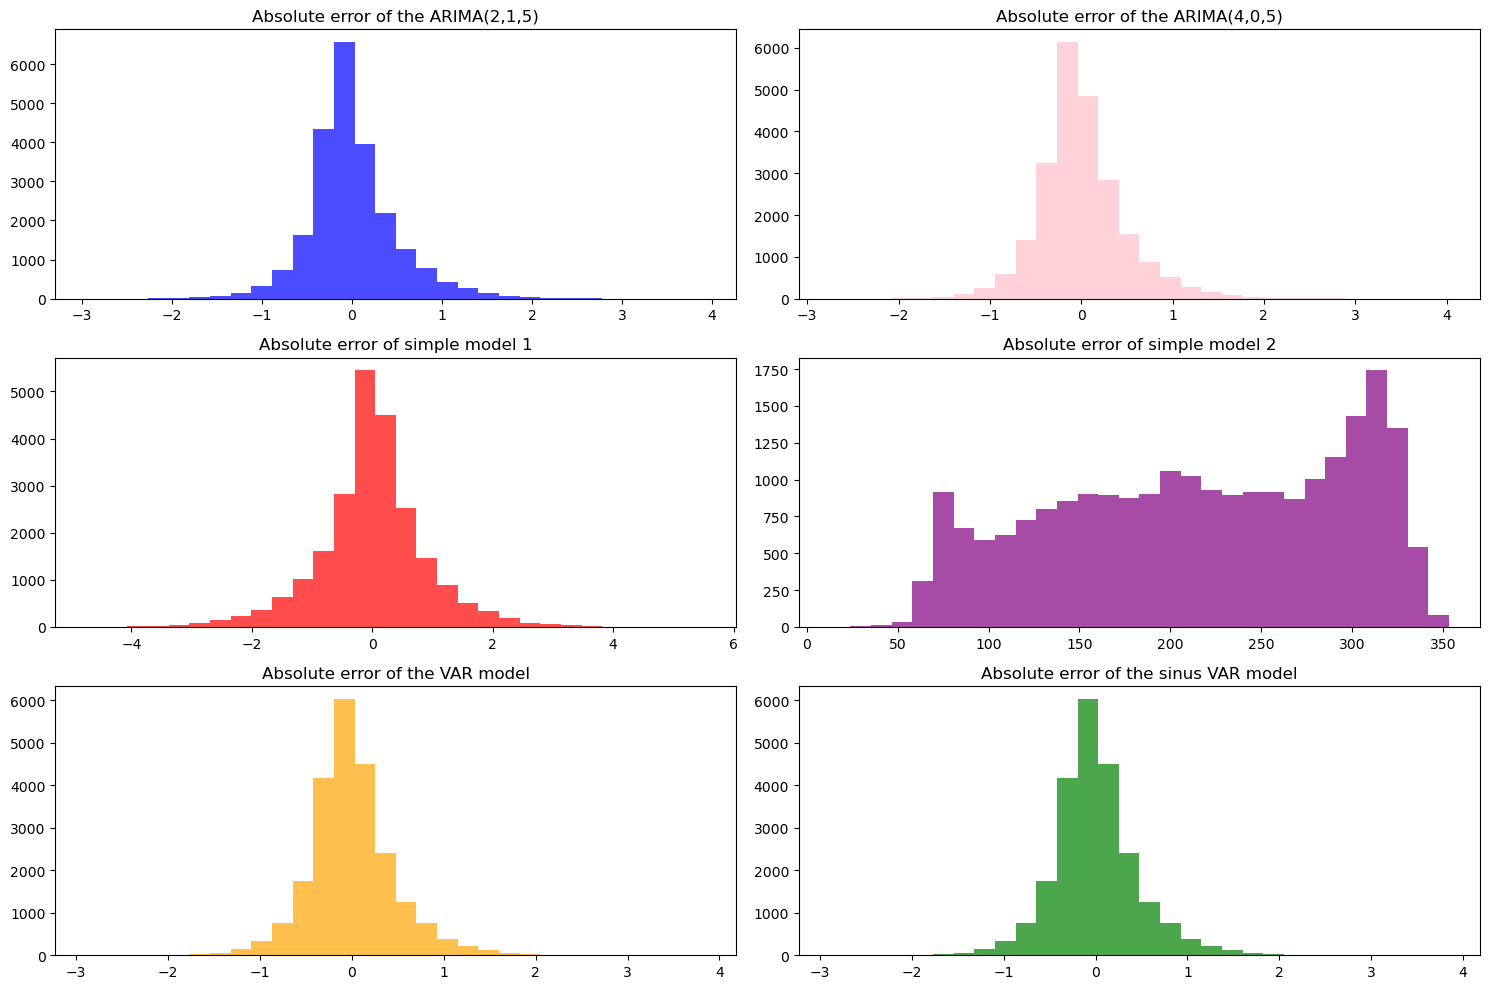

In [56]:
# histograms of the errors

plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.hist(error_arima_215, bins=30, color='blue', alpha=0.7)
plt.title('Absolute error of the ARIMA(2,1,5)')

plt.subplot(3, 2, 2)
plt.hist(error_arima_405, bins=30, color='pink', alpha=0.7)
plt.title('Absolute error of the ARIMA(4,0,5)')

plt.subplot(3, 2, 3)
plt.hist(error_simple_1_winds, bins=30, color='red', alpha=0.7)
plt.title('Absolute error of simple model 1')

plt.subplot(3, 2, 4)
plt.hist(error_simple_2_winds, bins=30, color='purple', alpha=0.7)
plt.title('Absolute error of simple model 2')

plt.subplot(3, 2, 5)
plt.hist(error_var_winds, bins=30, color='orange', alpha=0.7)
plt.title('Absolute error of the VAR model')

plt.subplot(3, 2, 6)
plt.hist(error_sinus_winds, bins=30, color='green', alpha=0.7)
plt.title('Absolute error of the sinus VAR model')

plt.tight_layout()
plt.show()